# Affect of Wind, Rain, RF, and Temperature on Spread of Future Wildfires

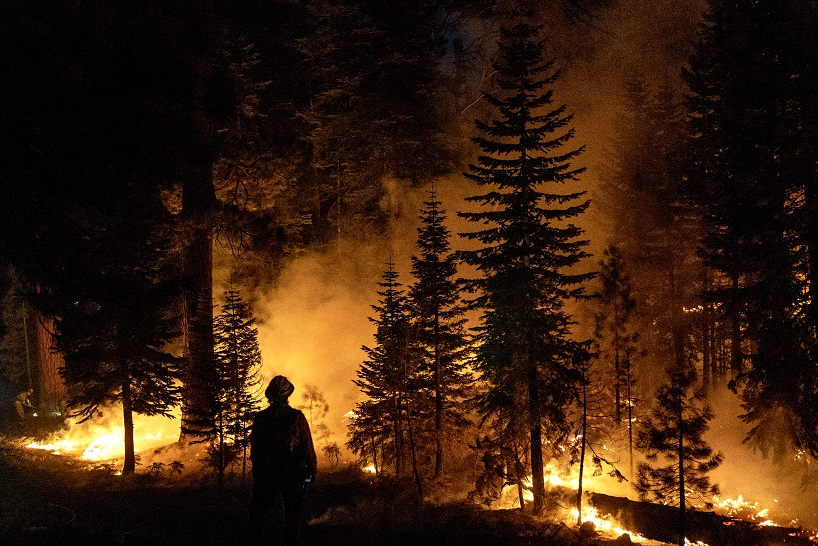

https://wildlife.ca.gov/portals/0/Images/Science_institute/Biodiversity/Wildfire/Donnell_fire.jpg

Project inspiration was drawn from this Article:

[1] Arif M, Alghamdi KK, Sahel SA, et al.(2021) Role of Machine Learning Algorithms in Forest Fire Management: A Literature Review. J Robotics Autom 5(1):212-226.
https://scholars.direct/Articles/robotics/jra-5-024.php?jid=robotics

[2] A Data Mining Approach to Predict Forest Fires using Meteorological Data: http://www3.dsi.uminho.pt/pcortez/fires.pdf

[3] An introduction to support vector regression svr https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2

[4] SVM Regression https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html

[5] Hypertuning the parameter https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

We wil be ultizing the forest fires Data set: https://archive.ics.uci.edu/ml/datasets/Forest+Fires. The dataset (forest.csv) is made available in this repository for reference.

# Goal of this investigation

#### Prediction of Spread of Wildfire (burned area in future) due to wind, rain, RF, and temperature respectivly 

We will build a machine learning pipeline to predict the spread of wildfire in the northeastern region of Portugal. This begans with preprocessing to standardize the data, and then Train_test_split to split the data into training and testing. A support vector regression model will be used to obtain a prediction. 

### Importing the Necessary Libraries and Defining Auxillary Functions

In [1]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Support Vector Machine Regression algorithm
from sklearn.svm import SVR
from sklearn import utils
# Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error as mae
# Cross Validation Object used for tuning hyperparamters of Regression Tasks
from sklearn.model_selection import RepeatedKFold

### Downloading Data

In [2]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_1403c94914e542249d4a494335cb6479 = 'https://s3.us.cloud-object-storage.appdomain.cloud'
else:
    endpoint_1403c94914e542249d4a494335cb6479 = 'https://s3.private.us.cloud-object-storage.appdomain.cloud'

client_1403c94914e542249d4a494335cb6479 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='lP1AA3pUGJVzdSkTSQd2yabrYNKkTSruQPkwmyDp6dHV',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_1403c94914e542249d4a494335cb6479)

body = client_1403c94914e542249d4a494335cb6479.get_object(Bucket='pythonbasicsfordatascienceproject-donotdelete-pr-g3yircsb5o9z4y',Key='forestfires.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

### Understading the Data 

The forestfires.csv contains model-specific info contains the following attribute information: [1]
1. temp - temperature in Celsius degrees: 2.2 to 33.30
2. RH - relative humidity in %: 15.0 to 100
3. wind - wind speed in km/h: 0.40 to 9.40
4. rain - outside rain in mm/m2 : 0.0 to 6.4
5. area - the burned area of the forest (in ha): 0.00 to 1090.84
(this output variable is very skewed towards 0.0, thus it may make
sense to model with the logarithm transform).

## 1.  Creating the data frame 

In [3]:
data = pd.read_csv(body)
# Reading the first five rows
data.head()
# Selecting the features we want to use for regression
cdf = data[['temp','RH','wind','rain','area']]
cdf.head()

,temp,RH,wind,rain,area
0,8.2,51,6.7,0.0,0.0
1,18.0,33,0.9,0.0,0.0
2,14.6,33,1.3,0.0,0.0
3,8.3,97,4.0,0.2,0.0
4,11.4,99,1.8,0.0,0.0


## 2. Cleaning, Preprocessing and Sorting the Data 

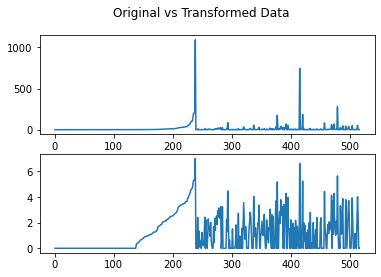

In [4]:
# New dataframe will contain our for predictors
features = cdf[['temp','RH','wind','rain']]

fig, axs = plt.subplots(2)
fig.suptitle('Original vs Transformed Data')

Y = cdf['area'].to_numpy()
Yold = Y
axs[0].plot(Y) # plotting by columns

# Transform the array data values with the ln(x+1) function
Y = np.log(Y+1)
axs[1].plot(Y) # plotting by columns

## 3. Forming the training and test data

Splitting the data into testing and training sets where we train the model using the training set and test with the testing set. This provides the model with an out-of-sample accuracy because the testing dataset is not part of the dataset used to train the model. Thus, providing a better understanding of how well our model generalizes on new data.

Let's split our dataset into train and test sets. Around 80% of the entire dataset will be used for training and 20% for testing. We create a mask to select random rows using the np.random.rand() function:

In [5]:
# Standardize the data in X then reassign it to the variable X 
transform = preprocessing.StandardScaler()
x_scaled = transform.fit_transform(features)
X = pd.DataFrame(x_scaled)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

## 4. Support Vector Regression

SVR objective function minimizes the coefficients through the l2 norm of the coefficient factor - rather than minimizing the sum of squared error like linear regression models. The error term is handled as a constraint setting the absolute error less than or equal to a user specified error, epsilon. Wherein, we can tune the epsilon as required to find an acceptable hyperplane to fit the data. [3] [4]

In [7]:
svmRBF = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svmRBF.fit(X_train, Y_train) #[4]

svmPOLY = SVR(kernel="poly", C=100, gamma=0.1, epsilon=0.1)
svmPOLY.fit(X_train, Y_train) #[4]
 
svmSigmoid = SVR(kernel="sigmoid", C=100, gamma=0.1, epsilon=0.1)
svmSigmoid.fit(X_train, Y_train) #[4]

SVR(C=100, gamma=0.1, kernel='sigmoid')

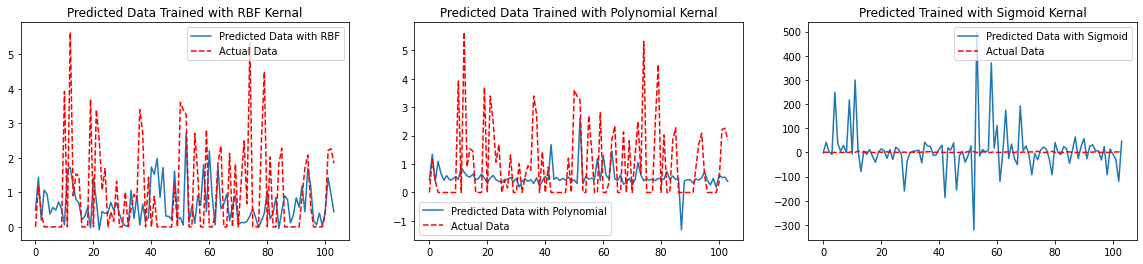

In [8]:
# Predict using our testset
yhatRBF = svmRBF.predict(X_test)
yhatPOLY = svmPOLY.predict(X_test)
yhatSigmoid = svmSigmoid.predict(X_test)

fig, axs = plt.subplots(1,3, figsize=(20, 4), squeeze = False)
#axs[0,0].plot(Y_test) 
#axs[0,0].set_title("Real Data", y=1)
axs[0,0].plot(yhatRBF) 
axs[0,0].plot(Y_test, 'r--')
axs[0,0].set_title("Predicted Data Trained with RBF Kernal", y=1)
axs[0,0].legend(['Predicted Data with RBF', 'Actual Data'])

axs[0,1].plot(yhatPOLY) 
axs[0,1].plot(Y_test, 'r--')
axs[0,1].set_title("Predicted Data Trained with Polynomial Kernal", y=1)
axs[0,1].legend(['Predicted Data with Polynomial', 'Actual Data'])

axs[0,2].plot(yhatSigmoid) 
axs[0,2].plot(Y_test, 'r--')
axs[0,2].set_title("Predicted Trained with Sigmoid Kernal", y=1) 
axs[0,2].legend(['Predicted Data with Sigmoid', 'Actual Data'])

## Defining a Metric 

As can be seen by the above graphs, a majority of the data points are not captured by any of three models. To account for the errors larger than epsilon, an appropriate regularization parameter, C , will be selected through Grid Search. [3] 

The metric we will use to score the choice of C will be the % of data points within Epsilon, otherwise defined as our margin of error. This is will be measured through Mean Absolute Error (MAE) as its score will vary with the choice of C. 

With the current C of 100, we find that the MAE for each of three graphs above are:

In [51]:
# Metric used is Mean Absolute Error (MAE)
# We compare againts Y_test because we are evaluting how well our model predicts the known data that was originally splitted in 3
maeRBF = mae(Y_test, yhatRBF)
maePOLY = mae(Y_test, yhatPOLY)
maeSigmoid = mae(Y_test, yhatSigmoid)

print("RBF Kernal: ", maeRBF)
print("Poly Kernal: ", maePOLY)
print("Sigmoid Kernal: ", maeSigmoid)

RBF Kernal:  1.0643737551057961
Poly Kernal:  0.9987238480454358
Sigmoid Kernal:  50.2430819715712


As seen above, the lowest score belongs to the Ploy Kernal followed by the RBF. The sigmoid kernal does not at all appeal to be a choice as it is 5 times in magnitude from RBF and Poly. 

##  5. Hyperparameter Tuning with GridSearch

The hyperparamter C will be tuned using Grid Search. As C increases, the tolerance for points ouside epsilon increases. Using GridSearch, we determine the optimal value for C. The value will be scored using MAE. This will be performed on all three kernal defined above to find the most optimal model.  

Below, we have determined the most optimal C score through manually tuning three hyperparamteres C, gamma, and epsilon

In [43]:
parameters = {'kernel':('rbf','poly','sigmoid'),'C': [100, 80, 70, 40],'gamma':[0.4, 0.3, 0.2, 0.1], 'epsilon':[0.1, 0.2, 0.3, 0.4]}


svr = SVR()
cv = RepeatedKFold(n_splits=2, n_repeats=2, random_state=1)
svr_cv = GridSearchCV(svr,parameters)
svr_cv.fit(X_train, (Y_train))
print("tuned hyperparamters  :(best parameters) ",svr_cv.best_params_)
print("accuracy :",svr_cv.best_score_)
yhat_svr_cv = svr_cv.predict(X_test)
print(svr_cv.score(X,Y), mae(Y_test, yhat_svr_cv))

tuned hyperparamters  :(best parameters)  {'C': 40, 'epsilon': 0.4, 'gamma': 0.1, 'kernel': 'rbf'}
accuracy : -0.1370625405139179
-0.020066538093429287 1.062167542713963


In [44]:
parameters = {'kernel':('rbf','poly','sigmoid'),'C': [40, 30, 20],'gamma':[0.7, 0.5, 0.4], 'epsilon':[0.1, 0.2, 0.3]}


svr2 = SVR()
svr_cv2 = GridSearchCV(svr2,parameters)
svr_cv2.fit(X_train, (Y_train))
print("tuned hyperparamters  :(best parameters) ",svr_cv2.best_params_)
print("accuracy :",svr_cv2.best_score_)
yhat_svr_cv2 = svr_cv2.predict(X_test)
print(svr_cv2.score(X,Y), mae(Y_test, yhat_svr_cv2))

tuned hyperparamters  :(best parameters)  {'C': 20, 'epsilon': 0.3, 'gamma': 0.4, 'kernel': 'rbf'}
accuracy : -0.24444962871197956
0.04286797934642561 1.092026080952143


In [45]:
parameters = {'kernel':('rbf','poly','sigmoid'),'C': [40, 41, 42],'gamma':[0.1, 0.12, 0.14], 'epsilon':[0.9, 0.92, 0.98]}


svr3 = SVR()
svr_cv3 = GridSearchCV(svr3,parameters)
svr_cv3.fit(X_train, (Y_train))
print("tuned hyperparamters  :(best parameters) ",svr_cv3.best_params_)
print("accuracy :",svr_cv3.best_score_)
yhat_svr_cv3 = svr_cv3.predict(X_test)
print(svr_cv3.score(X,Y), mae(Y_test, yhat_svr_cv3))

tuned hyperparamters  :(best parameters)  {'C': 40, 'epsilon': 0.98, 'gamma': 0.1, 'kernel': 'rbf'}
accuracy : -0.015366590078768705
0.04985430620253939 1.090313754250253


In [46]:
parameters = {'kernel':('rbf','poly','sigmoid'),'C': [40, 40.2, 40.5],'gamma':[0.1, 0.08, 0.05], 'epsilon':[0.9, 0.98, 1.0]}


svr4 = SVR()
svr_cv4 = GridSearchCV(svr3,parameters)
svr_cv4.fit(X_train, (Y_train))
print("tuned hyperparamters  :(best parameters) ",svr_cv4.best_params_)
print("accuracy :",svr_cv4.best_score_)
yhat_svr_cv4 = svr_cv4.predict(X_test)
print(svr_cv4.score(X,Y), mae(Y_test, yhat_svr_cv4))

tuned hyperparamters  :(best parameters)  {'C': 40, 'epsilon': 1.0, 'gamma': 0.08, 'kernel': 'rbf'}
accuracy : -0.012473741456748334
0.04499423210773179 1.0911797774108858


In [47]:
parameters = {'kernel':('rbf','poly','sigmoid'),'C': [40, 40.2, 40.5],'gamma':[0.1, 0.08, 0.4], 'epsilon':[0.1, 0.2, 0.3, 0.4]}


svr5 = SVR()
svr_cv5 = GridSearchCV(svr,parameters)
svr_cv5.fit(X_train, (Y_train))
print("tuned hyperparamters  :(best parameters) ",svr_cv5.best_params_)
print("accuracy :",svr_cv5.best_score_)
yhat_svr_cv5 = svr_cv5.predict(X_test)
print(svr_cv5.score(X,Y), mae(Y_test, yhat_svr_cv5))

tuned hyperparamters  :(best parameters)  {'C': 40.2, 'epsilon': 0.4, 'gamma': 0.08, 'kernel': 'rbf'}
accuracy : -0.13167970017969127
-0.02188547125274476 1.0535941180748423


In [30]:
parameters = {'kernel':('rbf','poly','sigmoid'),'C': [40, 40.1, 40.2],'gamma':[0.09, 0.085, 0.080], 'epsilon':[0.40, 0.42, 0.44]}


svr7 = SVR()
svr_cv7 = GridSearchCV(svr7,parameters)
svr_cv7.fit(X_train, (Y_train))
print("tuned hyperparamters  :(best parameters) ",svr_cv7.best_params_)
print("accuracy :",svr_cv7.best_score_)
yhat_svr_cv7 = svr_cv7.predict(X_test)
print(svr_cv7.score(X,Y), mae(Y_test, yhat_svr_cv7))

tuned hyperparamters  :(best parameters)  {'C': 40.1, 'epsilon': 0.44, 'gamma': 0.08, 'kernel': 'rbf'}
accuracy : -0.11931765489969728


1.0482912299745744

In [33]:
parameters = {'kernel':('rbf','poly','sigmoid'),'C': [40, 40.1, 40.05],'gamma':[0.08, 0.075, 0.070], 'epsilon':[0.44, 0.45, 0.47]}


svr8 = SVR()
svr_cv8 = GridSearchCV(svr8,parameters)
svr_cv8.fit(X_train, (Y_train))
print("tuned hyperparamters  :(best parameters) ",svr_cv8.best_params_)
print("accuracy :",svr_cv8.best_score_)
yhat_svr_cv8 = svr_cv8.predict(X_test)
print(svr_cv8.score(X,Y), mae(Y_test, yhat_svr_cv8))

tuned hyperparamters  :(best parameters)  {'C': 40.05, 'epsilon': 0.47, 'gamma': 0.07, 'kernel': 'rbf'}
accuracy : -0.10833501695753789
-0.01760514885279263 1.0432497688165794


In [41]:
parameters = {'kernel':('rbf','poly','sigmoid'),'C': [40.05,40.04,40.03 ],'gamma':[0.030, 0.05, 0.04], 'epsilon':[0.49, 0.48, 0.47]}


svr9 = SVR()
svr_cv9 = GridSearchCV(svr9,parameters)
svr_cv9.fit(X_train, (Y_train))
print("tuned hyperparamters  :(best parameters) ",svr_cv9.best_params_)
print("accuracy :",svr_cv9.best_score_)
yhat_svr_cv9 = svr_cv9.predict(X_test)
print(svr_cv9.score(X,Y), mae(Y_test, yhat_svr_cv9))

tuned hyperparamters  :(best parameters)  {'C': 40.05, 'epsilon': 0.49, 'gamma': 0.03, 'kernel': 'rbf'}
accuracy : -0.07441579456829832
-0.025601193446963322 1.0322994571650737


## Choice of parameters
After review the mae and the scores of each of the hyperparamter tunings, it was found that svr_cv8 had the minimum score and mae pairing of -0.01760514885279263 1.0432497688165794 respectivly. Thus, the optimal values were 'C': 40.05, 'epsilon': 0.47, 'gamma': 0.07, 'kernel': 'rbf'.

Whereby, the mae score from the original yhat_RBF of 1.06 has imporved by 2 hundreths as the current most optimal model has mae of 1.04/

Note that it was not possible to perform a more vigourous tuning using linspace on the numerical parameters like C because the fit() would timeout before producing any accurate results. Thus, the best method to retrieving optimal values was through manually defining discrete range of values. 

## Plot with the optimal hyperparameters

Text(0, 0.5, 'area - the burned area of the forest (in ha)')

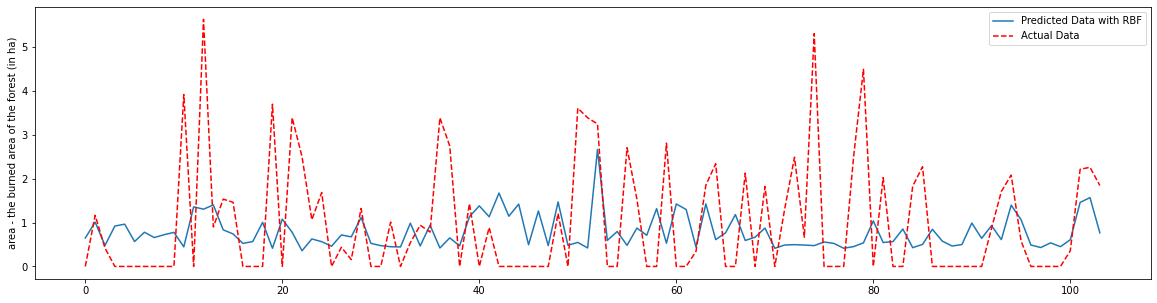

In [48]:
plt.figure(figsize=(20,5))
plt.plot(yhat_svr_cv8)
plt.plot(Y_test, 'r--')
plt.legend(['Predicted Data with RBF', 'Actual Data'])
plt.ylabel("area - the burned area of the forest (in ha)")

This chart shows a below adequte fit of the predctive data. At certain intervals like 70-80 we see that the predictive data falls flat rather than communicating the Actual data's maxima. However, at other points like 0 and 50-55 we se that the predictive data intersects with the actual data. Meanwhile, in intervals like 90-100 and 100+ we see that the predictive data trendline follows the actual data trendline.  

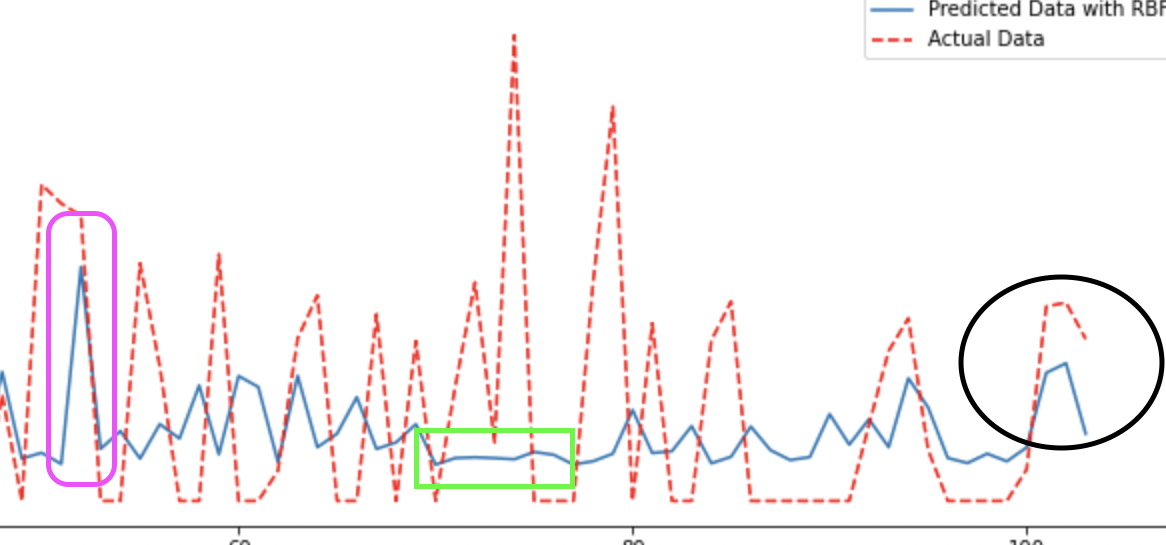

# Conclusion 

Looking at the graph above, it can be said that the graph did a an adequate job of fitting with provided data as the mae is 1.04. Moreover, the predictive data's trend follows the actual data graph line. Wherein, points of the predictive data also intersect with the actual data. 

To get a more precise Predicted Data model we would need more data. The increased data set would inturn increase the test and trained data and so the fitted data line would have more detailed trend lines to follow. With additional data, a more extensive hypertuning can be performed as the gridsearch would have a larger grid to tune for potential paramters. 

Unfortunalty, the papers which this research was inspired from did not provide any numerical results within the subsection of research I am conducting, so the benchmark must begain by being set more qualtitive info I have found on forest fires.

However, with the current dataset it is possible to surmise that wind, rain, RF, and temperature have some affect the spread of wildfires in the northeastern region of Portugal. To get a better estimation on the exact percentage of that effect, more data on forest near Portugal need to be taken in to consideration. The next steps of this paper will look in to expanding the data collection so this percentage of effect on the region by these 4 factors can be more accuratly predicted. 

By: Fatima Siddiqui 